# SeqTech 2024 Data Exploration

<a href="https://scanpy.readthedocs.io/en/stable/index.html">
    <img src="https://scanpy.readthedocs.io/en/stable/_static/Scanpy_Logo_BrightFG.svg" alt="Scanpy" style="width: 400px; float: left;"/>
</a>


This tutorial will make heavy use of "Scanpy" single-cell analysis package for Python.
https://scanpy.readthedocs.io/en/stable/

# AnnData Object Structure
Scanpy's core data structure is called [**AnnData**](https://anndata.readthedocs.io/en/latest/), for "Annotated Data". It was purpose-built for Scanpy, but in practice you can see it is an extremely flexible and generalizable data structure that you could use for all sorts of data science applications. That said, there are certain limitations to the `anndata` format, and some pipelines are starting to replace it with even more versatile structures, like [muon](https://muon.scverse.org/).   

<a href="https://anndata.readthedocs.io/en/latest/">
    <img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg" width=400, align=left>
</a>


<img align='left' src='https://raw.githubusercontent.com/jpreall/SeqTech_2023/main/images/Demux_schematic.png' width=600 />

# Import Libraries

In [1]:
import os, sys, glob, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
import scanpy as sc

# Which version of scanpy are we running?
sc.logging.print_version_and_date()

#Which versions other dependencies?
sc.logging.print_header()

# Set some defaults for displaying images in the notebook
# low dpi (dots per inch) yields small inline figures
sc.settings.set_figure_params(dpi=80,color_map='Reds')
pl.rcParams['figure.figsize'] = [4,4]


#sys.path.append('/grid/preall/home/jpreall/jpplot/')
sys.path.append('/Users/jpreall/Dropbox/Preall_Lab/Preall/scripts/jpplot/master/')
import jpplot
cj = jpplot.cmapjp()



Running Scanpy 1.10.3, on 2024-11-11 15:33.


/opt/miniconda3/envs/SeqTech24/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


# Load Data

In [55]:
datapath = '/Users/jpreall/Dropbox/Preall_Lab/SeqTech/SeqTech2023/data/AWS_package'

os.listdir(datapath)

['.DS_Store',
 'count',
 'demux',
 'aggr',
 'SeqTech_2023_Data_Exploration.ipynb',
 '.ipynb_checkpoints',
 'donor_id.csv',
 'SeqTech_2023_demux.ipynb']

In [56]:
datapath = '/Users/jpreall/Dropbox/Preall_Lab/SeqTech/SeqTech2023/data/AWS_package'
os.listdir(datapath + '/aggr/')

['.DS_Store', 'SeqTech23_BCR', 'SeqTech23_TCR', 'SeqTech23_GEX']

In [57]:
gexdir = datapath + '/aggr/SeqTech23_GEX/outs/count/'
tcrdir = datapath + '/aggr/SeqTech23_TCR/outs/vdj_t/'
bcrdir = datapath + '/aggr/SeqTech23_BCR/outs/vdj_b'
os.listdir(gexdir)

['summary.json',
 'filtered_feature_bc_matrix',
 'analysis',
 'cloupe.cloupe',
 'filtered_feature_bc_matrix.h5']

In [58]:
adata = sc.read_10x_h5(gexdir + 'filtered_feature_bc_matrix.h5')

/opt/miniconda3/envs/SeqTech24/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/SeqTech24/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [59]:
pd.Series(adata.var_names).value_counts()

TMSB15B           2
ARMCX5-GPRASP2    2
GGT1              2
GOLGA8M           2
HSPA14            2
                 ..
AC141272.1        1
AC023491.2        1
AC007325.1        1
AC007325.4        1
AC114498.1        1
Name: count, Length: 36591, dtype: int64

In [60]:
adata.var[:3]

,gene_ids,feature_types,genome,pattern,read,sequence
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,,,
FAM138A,ENSG00000237613,Gene Expression,GRCh38,,,
OR4F5,ENSG00000186092,Gene Expression,GRCh38,,,


In [61]:
adata.obs[:4]

""
AAACCTGAGACCTAGG-1
AAACCTGAGACTGTAA-1
AAACCTGAGGTCATCT-1
AAACCTGAGTATTGGA-1


In [4]:
#adata = jpplot.load_h5_elzar(gexdir + 'filtered_feature_bc_matrix.h5')
adata = sc.read_10x_h5(gexdir + 'filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
#adata.obs['Replicate'] = adata.obs['Library_ID'].str.split('_').str[1]
adata.obs['Replicate'] = adata.obs.index.str.split('-').str[-1]
#adata.obs.index = adata.obs.index.str.split('-Seq').str[0]


## Demux
demux_dir = f'{homedir}/demux/published_results/'
donor_ids_files = glob.glob(demux_dir + 'Seq*outdir/vireo_results/donor_ids*')
donors = pd.DataFrame()
for n,i in enumerate(sorted(donor_ids_files)):
    fullsamp = i.split('/')[-3]
    samp = fullsamp.split('_')[1]
    tmpdf = pd.read_table(i, index_col=0)
    tmpdf.index = tmpdf.index.str.split('-').str[0] + f'-{n+1}'
    donors = pd.concat([donors,tmpdf])
    
donors = donors.loc[adata.obs_names]
adata.obs[donors.columns] = donors
adata.obs['Sample'] = adata.obs['best_singlet']



/opt/miniconda3/envs/SeqTech24/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/SeqTech24/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# Let's look at what is currently stored in .X:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 16662221 stored elements and shape (16614, 36601)>

In [6]:
# Let's stash the raw counts as integers.
# Remember to call .copy() -- this ensures that the new thing being created isn't
# just a passive pointer to the original data, but is in fact a completely separate new object.
adata.layers['counts'] = adata.X.astype('int32').copy()

# Check that we have added the new layer:
print(adata.layers)

Layers with keys: counts


In [7]:
adata.layers['counts']

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 16662221 stored elements and shape (16614, 36601)>

## Cell-level metadata

Any per-cell annotation is stored in the **.obs** dataframe. This is a standard Pandas dataframe that can store cell type labels, numerical measures like UMI counts, sample metadata, or basically anything you might store in an Excel spreadsheet.

In [8]:
# Let's save a count of how many UMIs and unique genes are found in each cell:
# We will use Numpy for this simple math step
# The .A1 at the end reformats the data into a single 1-D flat array, rather than as a 1x5404 vertical stack.
# This is a dumb annoying thing about how Numpy arrays work

adata.obs['n_counts'] = np.sum(adata.layers['counts'], axis=1).A1

# Let's also save a count of the number of unique genes found in each cell:
# This counts how many genes have a UMI count > 0
adata.obs['n_genes'] = np.sum(adata.layers['counts'] > 0, axis=1).A1

# For good measure, let's also sort the UMI counts in log space
adata.obs['logUMIs'] = np.log10(adata.obs['n_counts'])

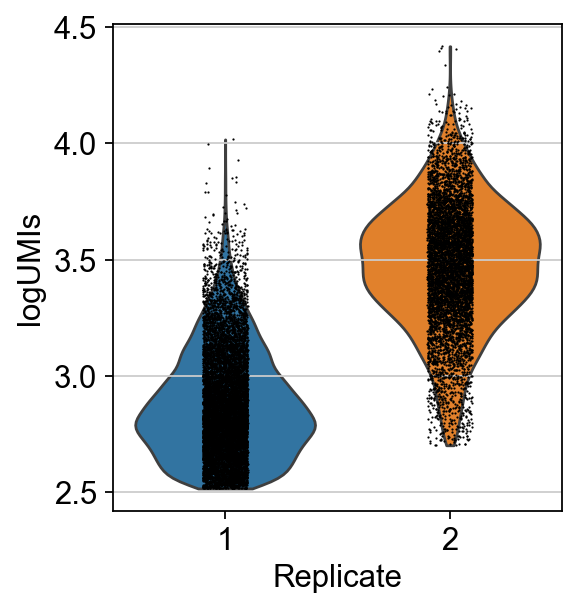

In [9]:
sc.pl.violin(adata, groupby='Replicate', keys='logUMIs')

In [10]:
# Let's see what that just added:
adata.obs[:5]

,Replicate,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,doublet_logLikRatio,Sample,n_counts,n_genes,logUMIs
AAACCTGAGACCTAGG-1,1,Osteo,1.000,4.900000e-12,143,Osteo,"Celiac,Osteo",-23.459,Osteo,1782,1093,3.250908
AAACCTGAGACTGTAA-1,1,Celiac,1.000,4.220000e-05,58,Celiac,"Celiac,Osteo",-7.491,Celiac,601,460,2.778874
AAACCTGAGGTCATCT-1,1,Osteo,0.979,1.810000e-02,33,Osteo,"Celiac,Osteo",-1.408,Osteo,506,392,2.704151
AAACCTGAGTATTGGA-1,1,Healthy,1.000,1.500000e-05,63,Healthy,"Healthy,Osteo",-8.527,Healthy,668,521,2.824776
AAACCTGAGTCCAGGA-1,1,Osteo,1.000,1.880000e-04,66,Osteo,"Celiac,Osteo",-5.999,Osteo,544,400,2.735599


In [11]:
outfile = f'{homedir}/donor_id.csv'
towrite = adata.obs['donor_id']
towrite.index = towrite.index.rename('Barcode')
towrite.to_csv(outfile)
pd.read_csv(outfile)

,Barcode,donor_id
0,AAACCTGAGACCTAGG-1,Osteo
1,AAACCTGAGACTGTAA-1,Celiac
2,AAACCTGAGGTCATCT-1,Osteo
3,AAACCTGAGTATTGGA-1,Healthy
4,AAACCTGAGTCCAGGA-1,Osteo
...,...,...
16609,TTTGTCAGTTAAGGGC-2,Rheuma
16610,TTTGTCATCATAACCG-2,Osteo
16611,TTTGTCATCCTCTAGC-2,Celiac
16612,TTTGTCATCGGAGCAA-2,Celiac


### Mitochondrial Genes
To help identify dead or dying cells, it is common to assess the fraction of reads coming from mitochondria, as we discussed in class. To do this, you need to know which genes are encoded by the mitochondrial genome.

One way to do this would be to use a package like GTFParse to read the transcriptome GTF file that was used to build the Cellranger reference, and pull out all the genes that are on chromosome 'MT'.  

Fortuntely, the human and mouse genomes make life easier. All human mitochondrial genes start with **'MT-'** and all mouse ones start with **'mt-'**

In [12]:
adata.var[:3]

,gene_ids,feature_types,genome,pattern,read,sequence
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,,,
FAM138A,ENSG00000237613,Gene Expression,GRCh38,,,
OR4F5,ENSG00000186092,Gene Expression,GRCh38,,,


In [13]:
# Use Python List comprehension to return a list of genes in the adata.var.index starting with 'MT-'
mito_genes = [name for name in adata.var.index if name.startswith('MT-')]
print(type(mito_genes))

<class 'list'>


In [40]:
# .var_names is an alias for adata.var.index that you may see used. Likewise, adata.obs_names
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]


In [17]:
# You could also accomplish the same thing by subscripting (ie., using [ ]) to slice the index
mito_genes = adata.var_names[adata.var_names.str.startswith('MT-')]

#### Compute the fraction mitochondrial

In [23]:
adata[:,mito_genes].layers['counts'].sum(1).A

array([[ 60],
       [ 13],
       [ 16],
       ...,
       [182],
       [ 79],
       [181]])

In [18]:
adata.obs['frac_mito'] = adata[:,mito_genes].layers['counts'].sum(1).A1 / adata.layers['counts'].sum(1).A1

<Axes: xlabel='Sample', ylabel='frac_mito'>

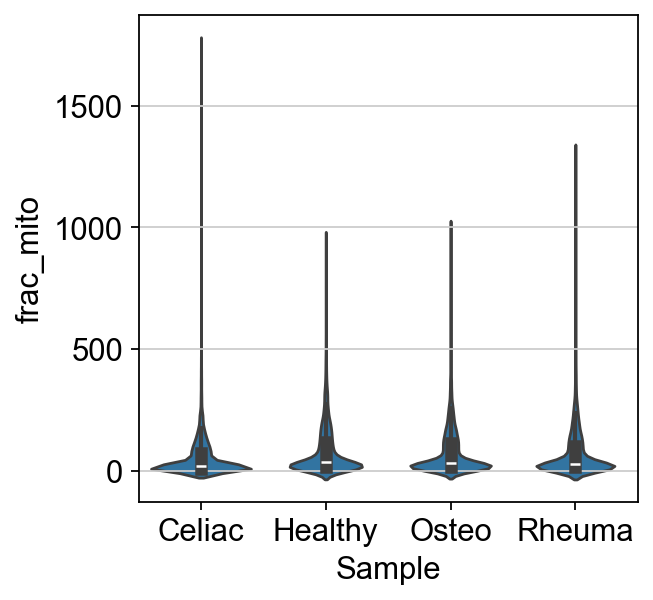

In [41]:
# Visualize the results using Seaborn

sns.violinplot(data=adata.obs, x='Sample', y='frac_mito')

# You can layer multiple plots on top of eachother.
# Try removing the comment and see how this layers a 'stripplot' over the 'violinplot'
#sns.stripplot(data=adata.obs, x='Sample', y='frac_mito', color='black', s=.5)

### Checkpoint
Make a backup of your largely unprocessed data here in case you want to come back to it later

In [18]:
unprocessed = adata.copy()

### Filter
Apply a QC filter to get rid of cells with a high fraction of mitochondrial reads, indicating cell death

In [19]:
adata = adata[adata.obs['frac_mito'] < 0.2].copy()

# Preprocessing and normalization
By default, Scanpy takes a very simple and straightforward approach to normalizing the gene expression levels across cells in the dataset:


$$ normCounts = (gene XCounts\:/\: totalCounts)\: x \:10^4$$

This is a big topic, with a lot of opinions about whether you should use much fancier methods:  
https://blog.bioturing.com/2022/01/27/a-guide-to-scrna-seq-normalization/  
https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1  
https://www.frontiersin.org/articles/10.3389/fgene.2020.00041/full

In [20]:
def preprocess(
    adata,
    target_sum=1e4,
    exclude_highly_expressed=True,
    max_fraction=0.05,
    max_scale_value = 10, # Max Z score to a allow a cell to have for any gene
    hvg_batch_key=None,
    ):
    
    sc.pp.normalize_total(
        adata,
        target_sum=target_sum, # "reads per 10k" is the norm for single-cell data, for some reason
        exclude_highly_expressed=exclude_highly_expressed, #If any cell is dominated by a given gene, exclude those from computing the normalization factor
        max_fraction = max_fraction)

    sc.pp.log1p(adata) # Adds a pseudocount of 1 to the matrix and takes the natural log

    # saves the log-normalized counts to a daughter object.
    # This will be called under the hood by differential expression and plotting tools
    adata.raw = adata.copy()

    return adata

preprocess(adata)

AnnData object with n_obs × n_vars = 16591 × 36601
    obs: 'Replicate', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Sample', 'n_counts', 'n_genes', 'logUMIs', 'frac_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    uns: 'Replicate_colors', 'log1p'
    layers: 'counts'

In [21]:
im

NameError: name 'im' is not defined

In [22]:
import numba
numba.__version__

'0.58.0'

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    batch_key=None, # Note, you could use 'Library_ID' here to apply a mild form of batch correction
    flavor='seurat',
)

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    batch_key=None, # Note, you could use 'Library_ID' here to apply a mild form of batch correction
    flavor='seurat')

### Highly variable gene selection

In [ ]:
# This should be done on the log-normalized data.
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    batch_key=None, # Note, you could use 'Library_ID' here to apply a mild form of batch correction
    flavor='seurat')

mito_genes = adata.var_names.str.startswith(("MT-"))
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))


print("Masking ribosomal and mitochondrial genes from highly variable...")
adata.var.highly_variable = adata.var.highly_variable.mask(ribo_genes, False)
adata.var.highly_variable = adata.var.highly_variable.mask(mito_genes, False)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
adata.var.query('highly_variable == True')


# Dimensionality Reduction

In [ ]:
def reduce_dimensions(
    adata,
    max_scale_value = 10,
    n_top_genes = 4000,
    use_highly_variable=True):
    
    # Z-score scale and centering raw data 
    # This is required for 
    sc.pp.scale(adata, max_value=max_scale_value)

    sc.pp.pca(adata, 
              #use_highly_variable=use_highly_variable, # deprecate, will eventually be removed
             mask_var='highly_variable', # the new preferred way to apply a mask
             )
    sc.pl.pca_variance_ratio(adata, log=True)
    
    return adata

reduce_dimensions(adata)

## Select number of PCs to use for clustering and visualization

In [ ]:
n_pcs=20

## A quick pause to visualize what our data currently looks like:

In [ ]:
gene='RPL6'


fig, ax = pl.subplots(
    3, # number of rows
    1, # number columns
    figsize=[8,6],
    )

ax[0] = sns.distplot(adata[:,gene].layers['counts'].toarray(), label='UMI counts', ax=ax[0])
ax[0].set_xlabel('Raw UMI counts')
ax[0].legend()

ax[1] = sns.distplot(adata.raw[:,gene].X.toarray(), label='raw.X (logNorm)', ax=ax[1])
ax[1].set_xlabel('log-normalized counts')
ax[1].legend()

ax[2] = sns.distplot(adata[:,gene].X, label='X (scaled)', ax=ax[2])
ax[2].set_xlabel('scaled counts')
ax[2].legend()

pl.suptitle(gene)
pl.tight_layout()

## Cluster cells
To identify cell clusters, we must first compute a neighbor graph. The first step of this is to compute all pairwise distances between cells in the dataset.  In the picture below, it is easy to imagine how to compute the distance between two points on the 2D plane.  For us, we are computing the graph in higher dimensions. Using all ~30k genes in the dataset would be crazy.  Instead, we are using the reduced dimension space we just computed via PCA to calculate these distances.  

The neighbor graph algorithm then figures out which cells are connected to which. Usually, the graph is pruned down to only the closest "K" nearest neighbors, hence the common name 'knn' graphs.  Scanpy uses a default of **knn=15**

The clustering algorithm uses a form of <a href="https://timoast.github.io/blog/community-detection/"> community detection via modularity optimization </a>. Basically, it tries to enclose communities of cells in bubbles, checks to see how many close neighbors got assigned to the same vs different bubbles, and then keeps tweaking those bubbles until it can't do any better at grouping like cells together.

<img src='https://miro.medium.com/max/738/1*skhjgApyDIPbJNolIZCF5w.png' width=300 align=left>

In [ ]:

sc.pp.neighbors(
    adata,
    #n_neighbors = 15, # default=15
    n_pcs = n_pcs,
    #metric = 'euclidean' # there are lots of possible distance metrics.  Try 'cityblock' or 'cosine'
)

# Clustering by Leiden modularity optimization
sc.tl.leiden(
    adata,
    resolution=0.5, # Try playing with this!
    key_added='Cluster' # This is the key that will appear in adata.obs with the new cluster names
    # You can repeat clustering again and again and give it a new key name each time, if you want
)


## Nonlinear Dimensionality Reduction

PCA helped reduce our dimensionality from ~30,000 down to ~50, but unfortunately our computer screens only easily display 2 dimensions.  
**tSNE** and **UMAP** are two commonly used to bring the number of dimensions down to 2 for visualization purposes. Keep in mind that the non-linearity of these methods means they are generally not very useful analytical tools.  Again, they are for *visualization*.  

**Which to use?**
UMAP has become more standard because it tends to better preserve global relationship between cell types. That is, very different cell types stay far away from one another, while similar cells are kind of packed in amorphously.  tSNE prioritizes local structure, emphasizing 'sub-cluster-level' details. But scRNA-seq data is so noisy, that focusing on these minute details is probably a waste of time.

<a href='https://pair-code.github.io/understanding-umap/'> Here is a super fun interactive explanation of the differences between UMAP and tSNE </a>


In [ ]:
# Compute tSNE projection
sc.tl.tsne(adata)

# Compute UMAP projection
sc.tl.umap(adata)

In [ ]:
sc.pl.tsne(adata, color='Cluster')

In [ ]:
sc.pl.umap(adata, color='Cluster')
sc.pl.umap(adata, color='Replicate')

## Filter cells

In [ ]:
backup = adata.copy()

In [ ]:
filter1 = adata.obs['n_counts'] > 600
filter2 = adata.obs['frac_mito'] < 0.2
adata.obs['OK']  = (filter1&filter2).astype('str')
adata.uns['OK_colors'] = ['#EE0000','#EEEEEE']
sc.pl.umap(adata, color=['frac_mito', 'logUMIs','OK'])

In [ ]:
adata = adata[adata.obs['OK'] == "True"].copy()
adata

In [ ]:
def redo_pca_cluster(
    adata: sc.AnnData,
    key_added: str = 'Subset_Cluster',
    n_pcs: int = 50,
    min_cells: int = 1,
    cluster_resolution: float = 0.5,
    n_top_genes: int = 4000,
    exclude_highly_expressed: bool = True,
    use_highly_variable: bool = True,
    hvg_batch_key=None,
    scale: bool = True,
    max_scale_value: int = 10,
    n_neighbors: int=15,
    use_local: bool = False,
    random_state: int = 0,
    ):

    print("Reclustering...")
    print("Using arguments:")
    print("n_pcs = ",n_pcs)
    #print("min_genes = ",min_genes)
    #print("min_counts = ",min_counts)
    print("min_cells = ",min_cells)
    print("cluster_resolution = ",cluster_resolution)
    print("n_top_genes = ",n_top_genes)
    print("use_highly_variable = ",use_highly_variable)

    print('Restoring raw counts from adata.layers[\'counts\']')
    adata.X = adata.layers['counts']

    sc.pp.normalize_total(
        adata,
        target_sum=1e4,
        exclude_highly_expressed=exclude_highly_expressed,
        key_added='Norm_Factor')

    print ('Log transforming...')
    sc.pp.log1p(adata)
    print ('Saving normalized log-transformed data to .raw')
    adata.raw = adata.copy()
    print('Done.')

    if use_highly_variable:
        print("Computing Highly Variable Genes with n_top_genes = {}...".format(n_top_genes))
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes=n_top_genes,
            batch_key=hvg_batch_key)

    else:
        if scale==True:
            print()
            print("Scaling .X layer to Z-scores with a max value of {}".format(max_scale_value))
            sc.pp.scale(adata, max_value=max_scale_value)

    print("PCA...")
    sc.pp.pca(adata, use_highly_variable=use_highly_variable, random_state=random_state)

    print("Computing KNN graph with n_pcs = {}...".format(n_pcs))
    sc.pp.neighbors(
        adata,
        n_pcs=n_pcs,
        n_neighbors=n_neighbors,
        random_state=random_state)

    #print("Computing UMAP...")
    sc.tl.umap(adata, random_state=random_state)

    print("Clustering by Leiden Modularity Optimization, cluster_resolution = {}...new clusters will be named: {}".format(cluster_resolution,key_added))
    sc.tl.leiden(adata,resolution=cluster_resolution, key_added=key_added, random_state=random_state)

    sc.pl.umap(adata, color=key_added)

In [ ]:
redo_pca_cluster(adata)

## Batch correction with Harmony

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41592-019-0619-0/MediaObjects/41592_2019_619_Fig1_HTML.png?as=webp" align=left>  

<img src="https://i.imgur.com/eAPbMJN.gif" width=300 align=left>  



<a href="https://www.nature.com/articles/s41592-019-0619-0"> Harmony paper by Korsunsky et al </a>

In [ ]:
def harmony(adata,
    batch_key='Sample',
    theta: float = 4, #harmony docs use 2.0 as default
    ridge_lambda: float = 1.0, #default
    sigma: float = 0.1, #default
    tau: int = 0, #default
    block_proportion: float = 0.05, #default
    max_iter_harmony=15,
    random_state=42,
    n_clusters_harmony: int = None,
    use_gpu=False,
    cluster_and_umap=True,
    key_added='Cluster_harmony',
    n_pcs=None,
    ):
    
    
    #requires pip install harmony-pytorch
    from harmony import harmonize

    if n_pcs:
        X = adata.obsm['X_pca'][:,:n_pcs]
    else:
        X = adata.obsm['X_pca']
    print('Computing harmonized PCA using {} PCs...'.format(X.shape[1]))
    Z = harmonize(
        X,
        adata.obs,
        batch_key = batch_key,
        max_iter_harmony=max_iter_harmony,
        random_state=random_state,
        use_gpu=use_gpu,
        theta=theta,
        ridge_lambda=ridge_lambda,
        sigma=sigma,
        tau=tau,
        n_clusters=n_clusters_harmony,
        block_proportion = block_proportion,
    )
    adata.obsm['X_harmony'] = Z
    print('Storing harmonized PCA in adata.obsm[\'X_harmony\']')

    if cluster_and_umap:
        sc.pp.neighbors(adata, use_rep='X_harmony', random_state=random_state)
        sc.tl.umap(adata, random_state=random_state)
        sc.tl.leiden(adata, resolution=0.5, key_added=key_added, random_state=random_state)
        sc.pl.umap(adata, color=key_added)

In [ ]:
harmony(adata, batch_key='Library_ID')

In [ ]:
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
jpplot.umap_interactive(adata)

In [ ]:
sc.pl.dotplot(adata, groupby='Sample', var_names=['XIST'])

# Cell Type Annotation
Chuan Xu, Martin Prete, Simone Webb, Laura Jardine, Benjamin J. Stewart, Regina Hoo, Peng He, Kerstin Meyer, Sarah A. Teichmann  
Automatic cell type harmonization and integration across Human Cell Atlas datasets.  
[bioRxiv 2023.05.01.538994 (2023)](https://www.biorxiv.org/content/10.1101/2023.05.01.538994v2)

<a href="https://www.celltypist.org/">
    <img src="https://www.celltypist.org/static/images/logo_celltypist.png" alt="CellTypist" style="width: 300px; float: left;"/>
</a>


In [ ]:
import celltypist
from celltypist import models

In [ ]:
#Show all available models that can be downloaded and used.
models.models_description()


In [ ]:
#Show all available models that can be downloaded and used.
models.models_description()

#Download a list of models, for example, `Immune_All_Low.pkl` and `Immune_All_High.pkl`.
models.download_models(model = ['Immune_All_Low.pkl', 'Immune_All_High.pkl'])


In [ ]:
#Show the local directory storing these models.
jpplot.ls(models.models_path)

In [ ]:
#Select the model from the above list. If the `model` argument is not provided, will default to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')


In [ ]:
#The model summary information.
model


In [ ]:
#Examine cell types contained in the model.
model.cell_types


In [ ]:
#Examine genes/features contained in the model.
print(model.features)
print('Number of features:', len(model.features))

In [ ]:

adata.layers['TP10K'] = adata.layers['counts'].multiply(1e4 / adata.layers['counts'].sum(1))
adata.layers['TP10K'] = np.log1p(adata.layers['TP10K'])

from scipy import sparse
adata.layers['TP10K'] = sparse.csr_matrix(adata.layers['TP10K'])



In [ ]:
adata_celltypist = adata.copy()
adata_celltypist.X = adata_celltypist.layers['TP10K']

predictions = celltypist.annotate(adata_celltypist, 
                                  model = 'Immune_All_Low.pkl',
                                  majority_voting=True)

In [ ]:
predictions.predicted_labels

In [ ]:
adata.obs['Predicted_Cell_Type'] = predictions.predicted_labels['predicted_labels']


sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color='Predicted_Cell_Type',
          #legend_loc='on data',
          #legend_fontsize=6,
          #legend_fontoutline=2
          )
sc.settings.set_figure_params(dpi=80)

In [ ]:
adata.obs['Cell_Type'] = predictions.predicted_labels['majority_voting']


sc.pl.umap(adata, color='Cell_Type',
          legend_loc='on data',
          legend_fontsize=6,
          legend_fontoutline=2)


In [ ]:
pd.crosstab(adata.obs['Replicate'], adata.obs['Cell_Type']).T

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='Cell_Type')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=2,)

## Make some plots!
Take a look at the documentation and see what other kinds of plots are available:  
### [Scanpy Plotting Manual](https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html)

In [ ]:
https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html